In [ ]:
!pip install transformers -q

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
from transformers import BertConfig, BertModel
from sklearn.model_selection import train_test_split

In [ ]:
class BERTBPETokenizer:
    def __init__(self, tokenizer, padding=True, truncation=True, max_length=512):
        self.tokenizer = tokenizer
        self.tokenizer.enable_padding(
            pad_id=tokenizer.token_to_id('[PAD]')
            , pad_type_id=0, pad_token='[PAD]')
        self.tokenizer.enable_truncation(max_length)
    
    @classmethod
    def from_pretrained(cls, path, padding=True, truncation=True, max_length=512):
        tokenizer = Tokenizer.from_file(path)
        return cls(tokenizer, padding=padding, truncation=truncation, max_length=max_length)
        
    def __call__(self, data):
        if isinstance(data, str):
            out = self.tokenizer.encode(data)
            input_ids = out.ids
            tokens = out.tokens
            attention_mask = out.attention_mask
            segment_id = out.type_ids
            
        elif isinstance(data, tuple):
            out = self.tokenizer.encode(data[0], data[1])
            input_ids = out.ids
            tokens = out.tokens
            attention_mask = out.attention_mask
            segment_id = out.type_ids
            
        elif isinstance(data, list):
            out_list =  self.tokenizer.encode_batch(data)
            input_ids, tokens, attention_mask,  segment_id = [], [], [], []
            for out in out_list:
                input_ids.append(out.ids)
                tokens.append(out.tokens)
                attention_mask.append(out.attention_mask)
                segment_id.append(out.type_ids)
        return input_ids, segment_id, attention_mask, tokens


def extract_bert_features(model, tokenizer, data, path):
    model.eval()
    with torch.no_grad():
        embed = []
        for x in tqdm(data):
            tkn_ids, sen_id, attn_msks, _ = tokenizer(x)
            y = model(input_ids=torch.tensor([tkn_ids]).to(dev)
            , attention_mask=torch.tensor([attn_msks]).to(dev)
            , token_type_ids=torch.tensor([sen_id]).to(dev))
            embed.append(list(y[1].cpu().detach().numpy()[0, :]))
        pd.to_pickle(np.array(embed), path)
    model.train()

In [ ]:
tokenizer = BERTBPETokenizer.from_pretrained(
    "/content/drive/MyDrive/ColabData/saved_models/PatientBERT/bert-bpe-icd.json",
    max_length=150
    )

In [ ]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(dev)

model = BertModel.from_pretrained('/content/drive/MyDrive/ColabData/saved_models/PatientBERT/mimic-3-bert-base')
model = model.to(dev)

Some weights of the model checkpoint at /content/drive/MyDrive/ColabData/saved_models/PatientBERT/mimic-3-bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
dfx = pd.read_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/pat_journey_data.pkl")
dfy = pd.read_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/target.pkl")

In [ ]:
dfx.head()

,pat_id,rx_count,px_journey,dx_journey,px_count,dx_count
0,2,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9955.0,V290 V053 V3001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",966.0 3893.0 9672.0 8964.0 9962.0 9604.0,2639 4254 6826 4280 41071 4275 5849 78559 0389,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4,"[0, 0, 0, 0, 4, 5, 4, 12, 4, 2, 1, 2, 4, 1, 1,...",3323.0 8872.0 3893.0,E9317 V090 04111 5715 7907 2763 7994 1363 042,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9955.0,V290 V053 V3000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,6,"[0, 0, 0, 0, 20, 0, 0, 1, 0, 0, 0, 1, 0, 8, 0,...",9904.0 3806.0 3957.0 91.0 5569.0,V1582 2753 2859 2767 2766 9972 4440 40391,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
cols_idx_map = pd.read_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/rx_col_idx_map.pkl")
idx_col_map = {v:k for k,v in cols_idx_map.items()}
col_lst = [idx_col_map[i] for i in range(len(cols_idx_map))]
len(cols_idx_map)

4354

In [ ]:
a = [0]*len(cols_idx_map)
no_rx_pats = []
for r,p in zip(dfx.rx_count, dfx.pat_id):
    if r==a:
        no_rx_pats.append(p)
print("Total patients without Rx data: ", len(no_rx_pats))

7187

*   Removing patients which have both Px and Dx missing
*   Also removing patients with missing Rx data




In [ ]:
df = dfx[(dfx.px_journey!='') & (dfx.dx_journey!='')]
print(df.shape)
df = df[~df['pat_id'].isin(no_rx_pats)]
df.shape

(41531, 6)


(35100, 6)

In [ ]:
targets = dfy[dfy.pat_id.isin(df.pat_id)]

In [ ]:
assert df.pat_id.tolist() == targets.pat_id.tolist()

In [ ]:
X1, X_test, y1, y_test = train_test_split(df, targets, test_size=0.20, random_state=42, stratify=targets['switch_flag'].tolist())
X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.15, random_state=42, stratify=y1['switch_flag'].tolist())

In [ ]:
X_train.head()

,pat_id,rx_count,px_journey,dx_journey,px_count,dx_count
38779,71883,"[0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...",9914.0 9904.0 9925.0 4131.0,6961 70721 70703 7850 78609 2631 2841 E8798 99...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
37840,68322,"[0, 0, 0, 0, 1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, ...",3961.0 3615.0 3613.0,78062 60000 2777 32723 27800 4019 2724 4111 41401,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
30512,40433,"[0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 3, 1, 0, ...",3891.0 9671.0,E9800 96500 34590 49390 29680 30000 5859 40390...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
36539,63407,"[0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 1, ...",3893.0 4595.0 5361.0 4582.0,45829 4019 V5861 42731 4928 4280 27652 55321 2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
40077,77053,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",3995.0 3895.0 5491.0 5523.0 4233.0 9604.0,E8798 2753 4589 4019 5839 5723 07054 99811 276...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**BERT Embeddings**

In [ ]:
for df, nm in zip([X_train, X_val, X_test], ['trn', 'val', 'test']):
    for col in ['px_journey', 'dx_journey']:
        path = f'/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/{nm}_{col}.pkl'
        extract_bert_features(model, tokenizer, df[col].tolist(), path)

In [ ]:
rx_trn = pd.DataFrame(np.array(X_train['rx_count'].tolist()), columns=col_lst, index=X_train['pat_id'])
rx_val = pd.DataFrame(np.array(X_val['rx_count'].tolist()), columns=col_lst, index=X_val['pat_id'])
rx_test = pd.DataFrame(np.array(X_test['rx_count'].tolist()), columns=col_lst, index=X_test['pat_id'])

**Rx Dimension Reduction** using Random Forest Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=10, random_state=0)

In [ ]:
clf.fit(rx_trn.values, y_train.switch_flag)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
df_imp = pd.DataFrame({'var_nm':col_lst, 'rf_imp': clf.feature_importances_}).sort_values('rf_imp', ascending=False).reset_index(drop=True)

In [ ]:
df_imp['cumsum'] = df_imp['rf_imp'].cumsum()*100

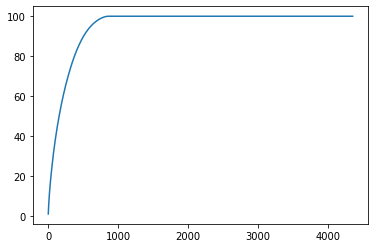

In [ ]:
plt.plot(df_imp['cumsum'])

In [ ]:
important_cols = df_imp[df_imp['cumsum']<=99.7]['var_nm'].tolist()
len(important_cols)

806

In [ ]:
pd.to_pickle(important_cols, "/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/imp_rx_cols.pkl")

In [ ]:
rx_trn[important_cols].to_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/imp_rx_trn.pkl")
rx_val[important_cols].to_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/imp_rx_val.pkl")
rx_test[important_cols].to_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/imp_rx_test.pkl")

In [ ]:
y_train.to_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/y_trn.pkl")
y_val.to_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/y_val.pkl")
y_test.to_pickle("/content/drive/MyDrive/ColabData/datasets/MIMIC-3/PatientLevel/y_test.pkl")